In [17]:
from IPython.display import display, Javascript

%load_ext autoreload
%autoreload 2

%store -r the_page
%store -r the_editor
%store -r agg_actions
%store -r editor_inputname
%store -r calculator
%store -r editors_conflicts

if ('the_page' not in locals() or 
    'the_editor' not in locals() or 
    'agg_actions' not in locals() or 
    'editor_inputname' not in locals() or 
    'calculator' not in locals() or 
    'editors_conflicts' not in locals()):
    
    import pickle
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))
    the_editor = pickle.load(open("data/the_editor.p",'rb'))
    agg_actions = pickle.load(open("data/agg_actions.p",'rb'))
    editor_inputname = pickle.load(open("data/editor_inputname.p",'rb'))
    calculator = pickle.load(open("data/calculator.p",'rb'))
    editors_conflicts = pickle.load(open("data/editors_conflicts.p",'rb'))

display(Javascript('IPython.notebook.execute_cells_below()'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

### <span style="color:green"> Modules Imported </span>

In [3]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output, Javascript
from datetime import datetime, date

# APIs
from external.wikipedia import WikipediaDV, WikipediaAPI

# Load and process data.
import pickle

# Visualization
import qgrid
from visualization.calculator_listener import ConflictCalculatorListener
from visualization.actions_listener import ActionsListener
from visualization.wordcloud_listener import WCListener

from utils.notebooks import get_date_slider_from_datetime

from ipywidgets import interact, Output, widgets, Layout
from ipywidgets.widgets import Dropdown

# Load the variables stored in the last notebook
%store -r the_page
%store -r total_actions
%store -r conflict_calculator
%store -r conflicts_by_editors
%store -r editor_info
%store -r editor_input_id

# Check them if in the namespace, otherwise load the default data.
if ('the_page' not in locals() or 
    'total_actions' not in locals() or 
    'conflict_calculator' not in locals() or 
    'conflicts_by_editors' not in locals() or
    'editor_info' not in locals() or
    'editor_input_id' not in locals()):
    
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))
    total_actions = pickle.load(open("data/agg_actions.p",'rb'))
    conflict_calculator = pickle.load(open("data/calculator.p",'rb'))
    conflicts_by_editors = pickle.load(open("data/editors_conflicts.p",'rb'))
    editor_info = pickle.load(open("data/the_editor.p",'rb'))
    editor_input_id = pickle.load(open("data/editor_inputname.p",'rb'))

---

# A.  Select an editor to analyze their conflicting editors

In [4]:
display(md(f"***Page: {the_page['title']}***"))

***Page: The Camp of the Saints***

The table below presents the conflict score and other related  metrics per editor 
(*editor_id* and *editor* column). Select one editor to analyze the editors that enter into 
conflict with her:

- **conflict_n**: the total number of conflicts
- **conflict**: the sum of conflict scores of all actions (without division)
- **actions**: the total number of actions performed by the editor
- **conflict_score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **conflict_ratio**: the count of all conflicts divided by the number of elegible actions

In [5]:
def display_conflict_score(eleg_actions):
    global listener
    
    
    listener = ConflictCalculatorListener(eleg_actions)

    metrics = ['Conflict Score', 'Absolute Conflict Score', 
               'Conflict Ratio',  'Number of Conflicts', 
               'Total Elegible Actions', 
               'Total Conflict Time', 'Total Elegible Time', 
               'Time per Conflict Action', 'Time per Elegible Action']

    display(md(f'*Total Page conflict score: {calculator.get_page_conflict_score()}*'))

    # Visualization

    interact(listener.listen,
             _range = get_date_slider_from_datetime(eleg_actions['rev_time']),
             granularity=Dropdown(options=['Yearly', 'Monthly', 'Daily'], value='Daily'),
             black=Dropdown(options=metrics, value='Conflict Score'),
             red=Dropdown(options= ['None'] + metrics, value='None'))

def select_editor(editor):
    global editor_df
    global the_editor
    global editor_inputname

    editor_inputname=editor
    
    wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))
    try:
        the_editor = wikipedia_dv.get_editor(int(editor_inputname))
    except:
        the_editor = wikipedia_dv.get_editor(editor_inputname[2:])

    with out:
        %store the_editor
        %store editor_inputname

        clear_output()
        display(md("### Current Selection:"))
        
        url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_inputname}&usprop=blockinfo|editcount|registration|gender&format=json'
        print("Editor's data can be found in:")
        print(url)
        if 'invalid' in the_editor:
            display(f"The editor {editor_inputname} was not found, try a different editor")
        else:
            # display the data that will be passed to the next notebook
            display(the_editor.to_frame('values'))
            display(md(f"#### Evolution of the Conflict Score of *{the_editor['name']}*"))

            editor_df = calculator.elegible_actions[
                calculator.elegible_actions['editor'] == str(editor_inputname)].copy()


            display_conflict_score(editor_df)


def on_selection_change(change):

    try:
        select_editor(qg_obj.get_selected_df().iloc[0].name)
    except:
        print('Problem parsing the name. Execute the cell again and try a different editor.')


qgrid.set_grid_option('maxVisibleRows', 5)
qg_obj = qgrid.show_grid(editors_conflicts)
qg_obj.observe(on_selection_change, names=['_selected_rows'])
                       
display(md("### Select one editor (row) to continue the demo:"))
display(md('**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*'))
display(qg_obj)
out = Output()
display(out)

select_editor(editor_inputname)

### Select one editor (row) to continue the demo:

**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Output()

In the above graph you can select the *date range* and *granularity* (yearly, montly) 
of the timeline (X-axis), and plot any of the following counts in the black and red lines:
   
- **Conflict Score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **Absolute Conflict Score**: the sum of conflict scores of all actions (without division)
- **Conflict Ratio**: the count of all conflicts divided by the number of elegible actions
- **Number of Conflicts**: the total number of conflicts
- **Total Elegible Actions**: the total number of elegible actions
- **Total Conflict Time**: the sum of all the times (*time_diff_secs*) that has been taken by conflict actions
- **Total Elegible Time**: the sum of all the times (*time_diff_secs*) that has been taken by elegible actions
- **Time per Conflict Action**: average time of conflict actions
- **Time per Elegible Action**: average time of elegible actions

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU SELECT AN EDITOR </span>

In [6]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU SELECT AN EDITOR                    ###
### ----------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## Use the variable from the last notebook: conflicts_by_editors (pd.DataFrame)        ##
## Display the dataframe using interactive grid, you could learn more through the doc: ##
## https://qgrid.readthedocs.io/en/latest/                                             ##
qgrid.set_grid_option('maxVisibleRows', 5)
qgrid_init = qgrid.show_grid(conflicts_by_editors)
display(qgrid_init)

## Get the editor info with Wikipedia API (get_editor() method), more details you could check: ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/api.py                        ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/wikipedia.py                  ##
wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))

# This is an example editor index. You could change it manully by typing in a new index from
# the above grid, e.g. 737021
editor_input_id = 44846

# store the editor_input_id for the usage in next notebook
%store editor_input_id

# Get the editor's information in the form of pd.DataFrame
editor_info = wikipedia_dv.get_editor(int(editor_input_id))

# store editor_info for the usage in next notebook
%store editor_info

## Display the basic information of the selected editor ##
editor_url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_input_id}&usprop=blockinfo|editcount|registration|gender&format=json'
print("Editor's data can be found in:")
print(editor_url)
display(md("### Current Selection:"))
display(editor_info.to_frame('values'))

## Interactive evolution of conflict score of this editor, using ConflictCalculatorListener, more details see ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/calculator_listener.py                  ##
display(md(f"#### Evolution of the Conflict Score of *{editor_info['name']}*"))

# Dataframe containing the info for interactive
editor_df = conflict_calculator.elegible_actions[conflict_calculator.elegible_actions['editor'] == str(editor_input_id)].copy()
           
# Create a ConflictCalculatorListener instance.
conflicts_cal_listener = ConflictCalculatorListener(editor_df)

# Set parameters
begin_date = date(2005, 3, 1)
end_date = date(2019, 6, 1)
frequency = 'Daily' # 'Monthly', 'Daily'

# The metrics we need:
# ['Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio', 'Number of Conflicts',
#  'Total Elegible Actions', 'Total Conflict Time', 'Total Elegible Time', 
# 'Time per Conflict Action', 'Time per Elegible Action', ('None')]
# Note: only 'red_line' has 'None' option.
black_line = 'Conflict Score'
red_line = 'None'
           
print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
print('Total Page conflict score:', conflict_calculator.get_page_conflict_score())
           
conflicts_cal_listener.listen(
    _range = (begin_date, end_date),
    granularity = frequency,
    black = black_line,
    red = red_line
)

The page that is being used: The Camp of the Saints


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Stored 'editor_input_id' (int)
Stored 'editor_info' (Series)
Editor's data can be found in:
https://en.wikipedia.org/w/api.php?action=query&list=users&ususerids=44846&usprop=blockinfo|editcount|registration|gender&format=json


### Current Selection:

,values
userid,44846
name,Gamaliel
editcount,80067
registration,2004-02-17T08:21:53Z
gender,male


#### Evolution of the Conflict Score of *Gamaliel*

Time range from 2005-03-01 to 2019-06-01
Total Page conflict score: 0.8699373285742629


---

# B. Detecting conflicting editors

In [7]:
display(md(f"***Page: {the_page['title']}***"))
display(md(f"""If editor {the_editor['name']} undo and action of editor B, editor B is called 
a conflicting editor. The following table shows the conflicting editors of {the_editor['name']} 
including their conflict score and other related metrics (see section A)."""))

***Page: The Camp of the Saints***

If editor P4k undo and action of editor B, editor B is called 
a conflicting editor. The following table shows the conflicting editors of P4k 
including their conflict score and other related metrics (see section A).

In [8]:
# create and display the button
button1 = widgets.Button(description="Show Detected Editors", layout=Layout(width='160px'))
display(button1)

def on_click_detect(b):
    global editors
    global conflicting_actions
    with out1:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))

        conflicting_actions = calculator.get_conflicting_actions(str(editor_inputname))

        wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))

        conflicting_editors = conflicting_actions['editor'].unique().tolist()

        editors = wikipedia_dv.get_editors([int(x) for x in conflicting_editors if x[:2] != '0|'])
        if len(editors) == 0:
            print('There is no other registered conflicting editor. Please try another one!')
        else:
            editors['userid'] = editors['userid'].astype('str')
            full_editors_conflicts = calculator.get_conflict_score_per_editor()
            display(editors[['userid','name','registration']].merge( full_editors_conflicts, 
                            right_index=True, left_on='userid',how='left').set_index('userid'))
                   
                   
out1 = Output()
display(out1)

# set the event
button1.on_click(on_click_detect)

# trigger the event with the default value
on_click_detect(button1)

Button(description='Show Detected Editors', layout=Layout(width='160px'), style=ButtonStyle())

Output()

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Detected Editors' Button </span>

In [9]:
### ------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Detected Editors' BUTTON  ###
### ------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'])
print('Selected editor:', editor_info['name'])

## Get the conflicting editors ##
# Get all conflcting actions of all editors through the previous instance 'conflict_calculator'
all_conflict_actions = conflict_calculator.get_conflicting_actions(str(editor_input_id))

# Get a list of conflicting editors.
all_conflict_editors = all_conflict_actions['editor'].unique().tolist()

# Eliminate those unregistered editors
final_editors = wikipedia_dv.get_editors([int(x) for x in all_conflict_editors if x[:2] != '0|'])

# Check if the list is empty.
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    final_editors['userid'] = final_editors['userid'].astype('str')
    
    # Conflict score for every editor.
    all_editors_conflicts = conflict_calculator.get_conflict_score_per_editor()
    
    # Include conflict information into table.
    display(final_editors[['userid','name','registration']].merge(all_editors_conflicts, 
                             right_index=True, left_on='userid', how='left').set_index('userid'))

The page that is being used: The Camp of the Saints
Selected editor: Gamaliel


,name,registration,conflict_n,conflict,action,conflict_score,conflict_ratio
userid,,,,,,,
28921814,NPalgan2,2016-08-09T02:06:23Z,311,259.503412,499,0.520047,0.623246
22888068,XavierItzm,2014-10-18T13:31:16Z,256,197.726186,256,0.772368,1.000000
35457216,Ishbiliyya,2018-12-24T23:19:58Z,20,9.874442,20,0.493722,1.000000
3002016,Black Kite,2006-12-12T00:51:40Z,48,75.150336,48,1.565632,1.000000
55582,Geni,2004-03-30T14:36:04Z,32,26.403502,32,0.825109,1.000000


---

# C. Activity of conflicting editors

In [10]:
display(md(f"***Page: {the_page['title']}***"))

***Page: The Camp of the Saints***

In the following graph you can select the conflicting *editor*, *date range* and 
*granularity* (yearly, montly) of the timeline (X-axis), and plot any of the follow counts in 
the black, red, blue and green lines:
   
- **adds**: number of first-time insertions
- **adds_surv_48h**: number of insertions for the first time that survived at least 48 hours
- **adds_persistent**:  number of insertions for the first time that survived until, at least, the end of the month
- **adds_stopword_count**:  number of insertions that were stop words
- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_persistent**: number of deletions that were not resinserted until, at least, the end of the month
- **dels_stopword_count**: number of deletions that were stop words
- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertionsthat survived at least 48 hours
- **reins_persistent**: number of reinsertionsthat survived until the end of the month
- **reins_stopword_count**: number of reinsertionsthat were stop words

In [11]:
# create and display the button
button2 = widgets.Button(description="Conflicting Editors Activity", layout=Layout(width='180px'))
display(button2)

def on_click_con_editor_act(b):
    global editors
    with out2:
        clear_output()
        if len(editors) == 0:
            print('There is no other registered conflicting editor. Please try another one!')
        else:
            editors['userid'] = editors['userid'].astype('int')
            conf_editor_agg_actions = editors[['userid','name','registration']].merge(agg_actions, 
                     left_on='userid', right_on='editor_id', how='left').set_index('userid')

            # Listener
            listener = ActionsListener(conf_editor_agg_actions)
            actions = (conf_editor_agg_actions.loc[:,'total':'total_stopword_count'].columns.append(
                conf_editor_agg_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()

            # Visualization
            interact(listener.listen, 
                     _range = get_date_slider_from_datetime(conf_editor_agg_actions['year_month']),
                     editor=Dropdown(options=['All'] + editors['name'].values.tolist(), value='All'),
                     granularity=Dropdown(options=['Yearly', 'Monthly'], value='Monthly'),
                     black=Dropdown(options=actions, value='total'), 
                     red=Dropdown(options= ['None'] + actions, value='total_surv_48h'),
                     green=Dropdown(options= ['None'] + actions, value='None'), 
                     blue=Dropdown(options= ['None'] + actions, value='None'))

out2 = Output()
display(out2)

# set the event
button2.on_click(on_click_con_editor_act)

# trigger the event with the default value
on_click_con_editor_act(button2)

Button(description='Conflicting Editors Activity', layout=Layout(width='180px'), style=ButtonStyle())

Output()

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Conflicting Editors Activity' Button </span>

In [20]:
### ------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Conflicting Editors Activity' BUTTON ###
### ------------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'])
print('Selected editor:', editor_info['name'])
print('Available Conflicting Editors:', final_editors['name'].tolist())

## First check if the list is empty. ##
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    ## Merge editors' all actions information into 'final_editors' table. ##
    final_editors['userid'] = final_editors['userid'].astype('int')
    conf_editor_total_actions = final_editors[['userid','name','registration']].merge(total_actions, 
                                             left_on='userid', right_on='editor_id', how='left').set_index('userid')
    
    ## Visualization, core visual code lies in ActionsListener, then the interact function    ##
    ## make it interactive, mode details see:                                                 ##
    ## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/actions_listener.py ##
    
    # Create an ActionsListener instance.
    actionslistener = ActionsListener(conf_editor_total_actions)
    
    # What types do those actions have?
    actions_types = (conf_editor_total_actions.loc[:,'total':'total_stopword_count'].columns.append(
                        conf_editor_total_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()
    
    # Visualization: try yourself by coding!
    begin_date = date(2002, 3, 1)
    end_date = date(2019, 4, 1)
    editor_name = 'All' # Select one conflicting name from the above list, or 'All'!
    frequency = 'Monthly' # 'Yearly', 'Monthly'
    black_line = 'adds' # Choose one from 'actions_types'. Note that 'black_line doesn't have 'None' option but others have.
    red_line = 'dels'
    blue_line = 'None'
    green_line = 'None'
    
    print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
    print("Current editor's name is", editor_name)
    
    actionslistener.listen(
        _range = (begin_date, end_date),
        editor = editor_name,
        granularity = frequency,
        black = black_line,
        red = red_line,
        blue = blue_line,
        green = green_line)

The page that is being used: The Camp of the Saints
Selected editor: Gamaliel
Available Conflicting Editors: ['NPalgan2', 'XavierItzm', 'Ishbiliyya', 'Black Kite', 'Geni']
Time range from 2002-03-01 to 2019-04-01
Current editor's name is All


---

# D. Tokens of conflicting editors

In [13]:
display(md(f"***Page: {the_page['title']}***"))

***Page: The Camp of the Saints***

The WordCloud displays the most common token strings (words) that a particular editor 
inserted or deleted and that enter into conflict with other editors. The size of the token string in 
the WordCloud indicates frequency of actions.

In the controls, you can select the conflicting *editor*, the *date range*, the type of *action* 
(insertion or deletion), and the *source*. The *source* can be any of the following:

-   **Only Conflicts**: use only the actions that are in conflict
-   **All Undos**: use all actions that involve and undo

In [14]:
# create and display the button
button3 = widgets.Button(description="Tokens of Conflicting Editors", layout=Layout(width='190px'))
display(button3)

def on_click_token_conflict(b):
    with out3:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))
        
        if len(editors) == 0:
           print('Thallere is no other registered conflicting editor. Please try another one!')
        else:      
            editors['userid'] = editors['userid'].astype('str')
            editor_conflicts = editors[['userid','name','registration']].merge(conflicting_actions, 
                     left_on='userid', right_on='editor', how='left').set_index('userid')
            sources = {
                f'Elegible Actions': editor_conflicts,
                f'Only Conflicts': editor_conflicts[~editor_conflicts['conflict'].isnull()]
            }

            # listener
            listener = WCListener(sources)

            # visualization
            interact(listener.listen, 
                     _range=get_date_slider_from_datetime(editor_conflicts['rev_time']),
                     editor=Dropdown(options=['All']  + editors['name'].values.tolist(), value='All', layout={'width': '400px'}),
                     source=Dropdown(options=list(listener.sources.keys()), value= f'Elegible Actions', layout={'width': '400px'}),
                     action=Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both', layout={'width': '400px'}))

out3 = Output()
display(out3)

# set the event
button3.on_click(on_click_token_conflict)

# trigger the event with the default value
on_click_token_conflict(button3)

Button(description='Tokens of Conflicting Editors', layout=Layout(width='190px'), style=ButtonStyle())

Output()

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Tokens of Conflicting Editors' Button </span>

The page that is being used: The Camp of the Saints
Selected editor: Gamaliel
Available Conflicting Editors: ['NPalgan2', 'XavierItzm', 'Ishbiliyya', 'Black Kite', 'Geni']
Time range from 2005-03-01 to 2019-07-04
Current editor's name is All


**Only top 100 most frequent words displayed.**

### The below token conflicts ocurred in a total of 10 revisions:

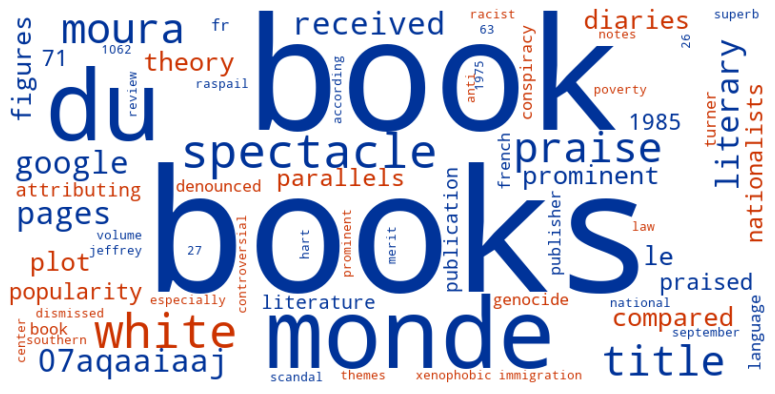

In [22]:
### -------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Tokens of Conflicting Editors' BUTTON ###
### -------------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'])
print('Selected editor:', editor_info['name'])
print('Available Conflicting Editors:', final_editors['name'].tolist())

## First check if the list is empty. ##
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    ## Include conflict token info into editors' basic information table. ##
    final_editors['userid'] = final_editors['userid'].astype('str')
    editor_in_conflicts = final_editors[['userid','name','registration']].merge(all_conflict_actions, 
                             left_on='userid', right_on='editor', how='left').set_index('userid')
    
    ## WordCloud, core visual code lies in WCListener, then the interact function               ##
    ## make it interactive, mode details see:                                                   ##
    ## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##
    
    # Define the token sources.
    wcsources = {
    f'Elegible Actions': editor_in_conflicts,
    f'Only Conflicts': editor_in_conflicts[~editor_in_conflicts['conflict'].isnull()]}

    # Create a WCListener instance
    wclistener = WCListener(wcsources)
    
    # Visualization: you could also perform it by coding!
    begin_date = date(2005, 3, 1)
    end_date = date(2019, 7, 4)
    editor='All' # Select one conflicting name from the above list, or 'All'!
    actions_source='Only Conflicts' # 'Elegible Actions', 'Only Conflicts'
    action_type='Both' # 'Just Insertions', 'Just Deletions', 'Both'
    

    print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
    print("Current editor's name is", editor)
    wclistener.listen(
         _range=(begin_date, end_date),
         source=actions_source,
         action=action_type,
         editor=editor)

In [18]:
from IPython.display import HTML
from utils.notebooks import get_next_notebook

display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))
